In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [153]:
# Read dataset file
df = pd.read_csv('/content/BTC.csv')
df = df[['Price']]
df = df.dropna()
df

,Price
0,13444.9
1,14754.1
2,15156.6
3,15180.1
4,16954.8
...,...
1938,27591.4
1939,27509.3
1940,28298.8
1941,28424.6


In [154]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [155]:
# Normalize the data
mean = train_data.mean()
meant = test_data.mean()
meanv = val_data.mean()
std = train_data.std()
stdt = test_data.std()
stdv = val_data.std()
train_data = (train_data - mean) / std
test_data = (test_data - meant) / stdt
val_data = (val_data - meanv) / stdv

In [156]:
# Prepare the data for CNN
window_size = 10

def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data.values, window_size)
X_test, y_test = create_sequences(test_data.values, window_size)
X_val, y_val = create_sequences(val_data.values, window_size)


In [158]:
# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [159]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/100
43/43 [==============================] - 2s 7ms/step - loss: 0.1882 - val_loss: 0.1019
Epoch 2/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0179 - val_loss: 0.0916
Epoch 3/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0151 - val_loss: 0.0817
Epoch 4/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0124 - val_loss: 0.0756
Epoch 5/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0111 - val_loss: 0.0737
Epoch 6/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0099 - val_loss: 0.0585
Epoch 7/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0538
Epoch 8/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0518
Epoch 9/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.0466
Epoch 10/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0447
Epoch 11/

In [160]:
# Make predictions
y_pred = model.predict(X_test)
# Inverse transform the predictions
y_pred = y_pred * pd.Series(stdt).values[0] + pd.Series(meant).values[0]

12/12 [==============================] - 0s 2ms/step


In [161]:
# Make predictions
y_vpred = model.predict(X_val)
# Inverse transform the predictions
y_vpred = y_vpred * pd.Series(stdv).values[0] + pd.Series(meanv).values[0]

6/6 [==============================] - 0s 2ms/step


In [162]:
df

,Price
0,13444.9
1,14754.1
2,15156.6
3,15180.1
4,16954.8
...,...
1938,27591.4
1939,27509.3
1940,28298.8
1941,28424.6


In [163]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
# re make predictions on the testing set
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
# re make predictions on the validate set
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
# calculate the RMSE
valid_rmse = np.sqrt(np.mean((y_vpred - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# calculate the MAPE
valid_mape = np.mean(np.abs((y_val - y_vpred) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Validation MAPE:", valid_mape)
print("Testing MAPE:", test_mape)

# calculate the MAE
valid_mae = np.mean(np.abs(y_vpred - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print("Validation MAE:", valid_mae)
print("Testing MAPE:", test_mape)

Validation RMSE: 6180.844894666011
Testing RMSE: 19530.425904722186
Validation MAPE: 23.27794262727685
Testing MAPE: 48.77176472835179
Validation MAE: 4941.639406212101
Testing MAPE: 48.77176472835179


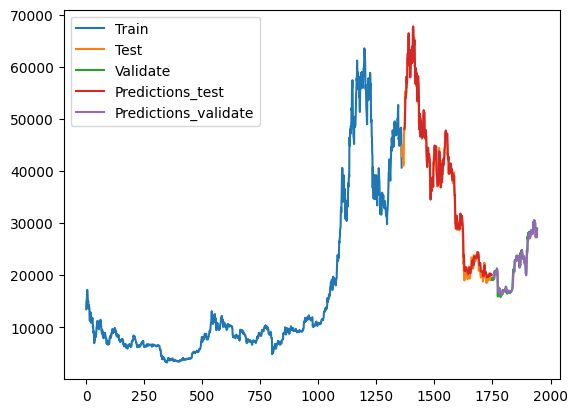

In [164]:
# ploting the actual values and predicted values
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])
plt.plot(test_data.index[-len(y_pred):], y_pred)
plt.plot(val_data.index[-len(y_vpred):], y_vpred)
plt.legend(['Train', 'Test','Validate', 'Predictions_test','Predictions_validate'])
plt.show()

In [165]:
y_val

array([19068.7, 19261.9, 19548.2, 19328.2, 19123.9, 19042.9, 19162.6,
       19204.8, 19571.2, 19331.5, 20082.7, 20769.5, 20292.9, 20594.4,
       20809.8, 20626.3, 20496.3, 20483.5, 20154.4, 20206.4, 21145.9,
       21301.6, 20916.3, 20589. , 18527.4, 15886.9, 17589.1, 17049.9,
       16795.2, 16324.5, 16613.7, 16895.1, 16540.5, 16691.2, 16638.3,
       16699.2, 16286.7, 15776.2, 16212.9, 16623.9, 16601.2, 16512.3,
       16456.5, 16425.6, 16211.7, 16440.4, 17163.9, 16972. , 17093.6,
       16884.5, 17112.6, 16966.5, 17089.3, 16835.2, 17225.7, 17125.7,
       17127.2, 17093.3, 17210.4, 17778.6, 17796.4, 17356.1, 16629.6,
       16777.1, 16741.1, 16441.3, 16902.8, 16831.8, 16820.6, 16779.1,
       16837.2, 16831.8, 16918.1, 16706.1, 16546.2, 16636.4, 16607.2,
       16537.4, 16618.4, 16674.3, 16674.2, 16852.1, 16829.8, 16950.9,
       16943.6, 17119. , 17180.1, 17439.1, 17942.3, 18851.3, 19927. ,
       20958.2, 20879.8, 21184.2, 21137.1, 20670.6, 21081.2, 22677.2,
       22775.7, 2270

In [167]:
y_vpred

array([[19397.984],
       [19710.176],
       [20575.293],
       [20361.037],
       [20308.818],
       [20835.412],
       [20621.037],
       [20569.518],
       [20548.316],
       [20154.   ],
       [20127.684],
       [20704.463],
       [21166.254],
       [20890.117],
       [20583.555],
       [18965.58 ],
       [17386.5  ],
       [16945.22 ],
       [17667.791],
       [17167.379],
       [16613.24 ],
       [16610.875],
       [17505.277],
       [17049.283],
       [16675.037],
       [16816.312],
       [16799.453],
       [16553.58 ],
       [16291.513],
       [16195.113],
       [16553.6  ],
       [16590.309],
       [16564.266],
       [16663.895],
       [16616.059],
       [16463.752],
       [16422.61 ],
       [16740.209],
       [16901.996],
       [16877.25 ],
       [16969.912],
       [16899.92 ],
       [17034.26 ],
       [17036.92 ],
       [16972.934],
       [17036.55 ],
       [17188.262],
       [17166.691],
       [17233.451],
       [17239.576],
